In [185]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io 

In [65]:
adnifulldf = pd.read_csv("ADNI/adnitable.csv")

In [66]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [67]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [68]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [69]:
petdf.DX.value_counts()

CN    594
AD    530
Name: DX, dtype: int64

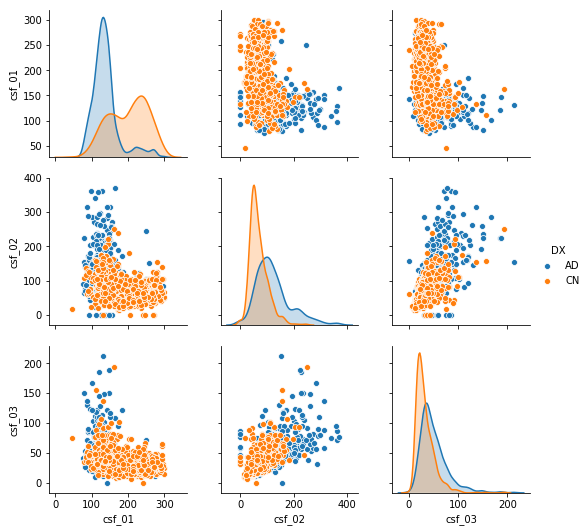

In [25]:
sns.pairplot(csfdf, hue="DX", vars=csf_vars, diag_kind='kde', diag_kws=dict(shade=True))
plt.show()

In [70]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


# Different classifiers for each data modality

## Amyloid

In [121]:
# prepare data with appropriate features and randomization
shuffled_df = amyloiddf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], amyloid_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=4)
# mlmodel = SVC(C=1e1, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=4)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 75.36, Specificity: 84.42
Train: Sensitivity = 79.37, Specificity: 88.63


## FDG

In [140]:
## prepare data with appropriate features and randomization
shuffled_df = fdgdf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], fdg_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=4)
# mlmodel = SVC(C=1e0, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=4)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 75.76, Specificity: 87.56
Train: Sensitivity = 85.59, Specificity: 89.57


## CSF

In [154]:
## prepare data with appropriate features and randomization
shuffled_df = csfdf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], csf_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e1, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 84.00, Specificity: 81.34
Train: Sensitivity = 85.50, Specificity: 83.61


## PET

In [181]:
## prepare data with appropriate features and randomization
shuffled_df = petdf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], pet_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e-1, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 50.52, Specificity: 82.81
Train: Sensitivity = 58.89, Specificity: 84.98


## MRI

In [188]:
## prepare data with appropriate features and randomization
shuffled_df = mridf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], mri_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
mlmodel = SVC(C=1e0, kernel='linear')
# mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 85.49, Specificity: 93.44
Train: Sensitivity = 86.98, Specificity: 93.83
